# Verificação de Aprendizagem - Machine Learning

## Experimentos

### Carregando os Dados

In [2]:
import pandas as pd
import numpy as np
import re

import unicodedata
from sklearn.model_selection import train_test_split

In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = w.strip().lower()

    # creating a space between a word and the punctuation following it eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping
    # -punctuation
    w = re.sub(r"([?.!,¿#@0-9])", r"", w)

    return w

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

In [5]:
samples = pd.read_csv('datasets/samples.csv')
X = samples['TEXT'].apply(preprocess_sentence).to_numpy()
y = samples['LANG'].to_numpy()

pd.DataFrame.from_dict(Counter(y), orient='index')

,0
apalai,100
apinaye,100
apurina,100
bakairi,100
guajajara,100
guarani,100
kadiweu,100
kagwahiva,100
kaigang,100
kaiwa,100


In [6]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2, 3))
X_transformed = tfidf.fit_transform(X)

### Análise Usando TSNE

Em análise preliminar, pode-se ver na figura a disposição dos idiomas em uma projeção 2D. 
Foi utilizado *t-distributed Stochastic Neighbor Embedding* (TSNE) para a redução da dimensionalidade e uma visualização dos dados.
Essa é uma forma bastante popular para visualização de dados em alta-dimensionalidade.
Nessa técnica os objetos são distribuídos de tal forma que pares semelhantes tem uma alta probabilidade na distribuição.
O modelo é treinado para minimizar a divergência em Kullback-Leibler *van2014accelerating*.
Após a redução da dimensionalidade das originais 18095 para apenas duas,  os dados foram postos em uma escala entre 0 e 1.

In [7]:

X_embedded = TSNE(n_components=2).fit_transform(X_transformed)    
X_embedded.shape

(2700, 2)

### Normalizando 

Aqui os dados são colocados entre 0 e 1

### Visalização 

Em análise preliminar, pode-se ver na figura a disposição dos idiomas em uma projeção 2D. 
Foi utilizado (TSNE) para a redução da dimensionalidade e uma visualização dos dados.
Essa é uma forma bastante popular para visualização de dados em alta-dimensionalidade.
Nessa técnica os objetos são distribuídos de tal forma que pares semelhantes tem uma alta probabilidade na distribuição.
O modelo é treinado para minimizar a divergência em Kullback-Leibler *van2014accelerating*.
Após a redução da dimensionalidade das originais 18095 para apenas duas,  os dados foram postos em uma escala entre 0 e 1.

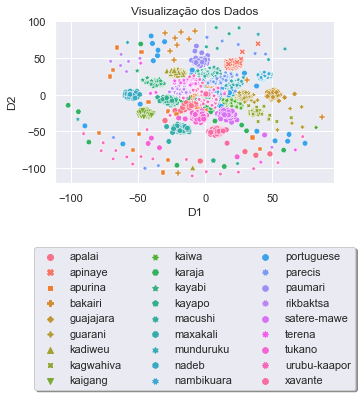

In [9]:
import matplotlib.pyplot as plt

import seaborn as sns

df = pd.DataFrame(X_embedded, columns=['D1', 'D2'])
df['Language'] = y
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(5.,3)})
g = sns.scatterplot(data=df, x="D1", y="D2", hue="Language", style="Language")
g.legend(loc='lower center', bbox_to_anchor=(0.5, -1.3),
          ncol=3, fancybox=True, shadow=True)
g.set_title("Visualização dos Dados")
plt.savefig('tsne_vis.pdf')

### Preprocessando e Extraindo Features

In [10]:
CLFS_LIST = [('LinearSVC',LinearSVC()),
             ('MultinomialNB',MultinomialNB()),
             ('LogisticRegression',LogisticRegression())]

def run_experiment(X_, y_):
 
  exp_results = pd.DataFrame({'accuracy': [],'classifier_name':[],'fit_time':[]})
  cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=42)
  
  for clf in CLFS_LIST:
    step = 1
    clf_name, estimator = clf
    print(f"Treinando {clf_name}...")
    scores = cross_validate(estimator, X_, y_, cv=cv,
                            scoring=('accuracy', 'f1_macro'),
                            return_train_score=False)
    exp_df = pd.DataFrame({
        'accuracy':scores['test_accuracy'],
        'f1_macro':scores['test_f1_macro'],
        'classifier_name':[clf_name for _ in range(10)],
        'fit_time':scores['fit_time']+scores['score_time'],
        'dataset_name':['dataset'+str(i) for i in range(step, step+10)]
    })
    exp_results = exp_results.append(exp_df)
 
  return exp_results.fillna(0)

In [ ]:
result_df = run_experiment(X_transformed, y)
result_df.to_csv('results/result_tf.csv')

Treinando LinearSVC...
Treinando MultinomialNB...
Treinando LogisticRegression...


In [ ]:
groups = result_df.groupby(['classifier_name'])
summary = groups.agg({'accuracy':['mean', 'median', 'std'], 'fit_time':'mean'})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['Média', 'Mediana', 'Desvio Padrão', 'Tempo Médio']

open('results/result_acc.txt', 'w', encoding='utf-8').write(summary.to_latex())
summary

In [ ]:
groups = result_df.groupby(['classifier_name'])
summary = groups.agg({'f1_macro':['mean', 'median', 'std'], 'fit_time':'mean'})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['Média', 'Mediana', 'Desvio Padrão', 'Tempo Médio']

open('results/result_f1.txt', 'w', encoding='utf-8').write(summary.to_latex())
summary

### Experimentos Usando TSNE

In [18]:
!git clone https://github.com/Tiagoblima/cd-diagram.git

Cloning into 'cd-diagram'...


In [19]:
from IPython.display import Image, display

!python cd-diagram/main.py --results results/result_tf.csv --metric accuracy --img cd-diagram1.png
display(Image('images/cd-accuracy.png'))

['LinearSVC' 'MultinomialNB' 'LogisticRegression']
LinearSVC             10.0
LogisticRegression     0.0
MultinomialNB          0.0
dtype: float64
MultinomialNB         2.8
LogisticRegression    2.2
LinearSVC             1.0
dtype: float64
('LinearSVC', 'LogisticRegression', 0.001953125, True)
('LinearSVC', 'MultinomialNB', 0.001953125, True)
('LogisticRegression', 'MultinomialNB', 0.013671875, True)
Index(['MultinomialNB', 'LogisticRegression', 'LinearSVC'], dtype='object')


FileNotFoundError: No such file or directory: 'cd-accuracy.png'

FileNotFoundError: No such file or directory: 'cd-accuracy.png'

<IPython.core.display.Image object>

['LinearSVC' 'MultinomialNB' 'LogisticRegression']
LinearSVC             10.0
LogisticRegression     0.0
MultinomialNB          0.0
dtype: float64
MultinomialNB         2.9
LogisticRegression    2.1
LinearSVC             1.0
dtype: float64
('LinearSVC', 'LogisticRegression', 0.001953125, True)
('LinearSVC', 'MultinomialNB', 0.001953125, True)
('LogisticRegression', 'MultinomialNB', 0.005859375, True)
Index(['MultinomialNB', 'LogisticRegression', 'LinearSVC'], dtype='object')


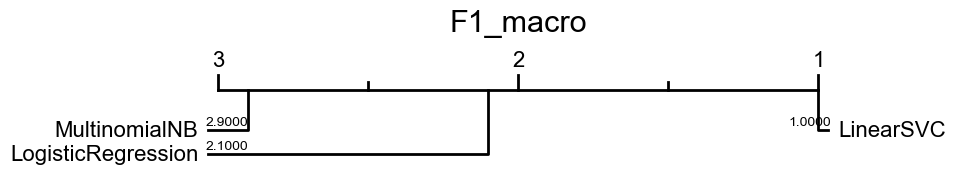

In [20]:
from IPython.display import Image, display

!python cd-diagram/main.py --results results/result_tf.csv --metric f1_macro --img cd-f1_macro.png
display(Image('images/cd-f1_macro.png'))

In [ ]:
clf = LinearSVC(max_iter=5000)
clf.fit(X_train, y_train)

plot_confusion_matrix(clf, X_test, y_test)
plt.show()